# EE P595 Homework 2: Breaking CAPTCHAs End-to-End

In lab 3, we have successfully built a pipeline that automatically recognizes CAPTCHAs. So far, the recognition process requires manually identifying contours (and subsequently bounding boxes) around characters using expert rules, before performing classification on extracted character images. This inspires us for possible further improvement: can we use a single neural network to directly identify CAPTCHA characters from CAPTCHA image? In this homework, we will get rid of bounding box identification and build an end-to-end neural network model.

Like previous labs and homeworks, your task is to complete all missing code, improvement tasks and also answer questions related to the training process. When you have finished this homework, please submit this notebook as an archive with neural network model files (see "Submission" section for details).

## Pre-processing

Like usual, we start with data pre-processing step and we load all CAPTCHA images into memory. This time we use Keras's image utilities to do the job:

In [324]:
import os

import numpy as np
from tensorflow.keras.preprocessing.image import load_img

# Image file extensions
IMAGE_EXTS = set((".png", ".jpg"))
# CAPTCHA images directory
CAPTCHA_IMAGES_DIR = "./captcha-images"

# CAPTCHA images
captcha_images = []
# CAPTCHA texts
captcha_texts = []

## [ TODO ]
# 1) Load all CAPTCHA images from `CAPTCHA_IMAGES_DIR` into `captcha_images`
#    (Your code should ignore non-image files)
# 2) Convert CAPTCHA images into NumPy array and add an extra channel dimension
# 3) Load all CAPTCHA texts into `captcha_texts`
#    (Items in `captcha_images` and `captcha_texts` should match)

for i in os.listdir(CAPTCHA_IMAGES_DIR):
    if i[-4:] in IMAGE_EXTS:
        image=np.array(load_img(CAPTCHA_IMAGES_DIR+'/'+i,color_mode='grayscale'))
        captcha_images.append(image)
        captcha_texts.append(i[:4])
captcha_images=np.array(captcha_images).reshape(len(captcha_images),24,72,1)


assert isinstance(captcha_images, np.ndarray), "`captcha_images` must be a NumPy array!"
assert captcha_images.ndim==4, "`captcha_images` should have shape (n_images, h, w, 1)"
assert len(captcha_images)==len(captcha_texts), \
    "`captcha_images` should have the same number of elements as `captcha_texts`"

Then, we split all CAPTCHA images and texts into training-validation and test sets:

In [325]:
from sklearn.model_selection import train_test_split

# Training-validation-test split seed
TVT_SPLIT_SEED = 31528476

# Split dataset into training and test sets
captcha_images_tv, captcha_images_test, captcha_texts_tv, captcha_texts_test = train_test_split(
    captcha_images, captcha_texts, test_size=0.2, random_state=TVT_SPLIT_SEED
)

Next, we encode each character in the CAPTCHA text with one-hot vectors:

In [326]:
from sklearn.preprocessing import LabelBinarizer
import hw2_util

## [ TODO ]
# 1) Flatten training-validation CAPTCHA texts into list of characters
#    (Hint: `hw2_util.flatten` can help you with that)
# 2) One-hot encode these characters
# 3) Save number of classes (distinct characters) in `n_classes`
# 3) Group every four one-hot encoded characters for each CAPTCHA as `texts_one_hot_tv`
#    (The shape of `texts_one_hot_tv` should be (n_images, 4, n_classes))
captcha_texts_tv=list(hw2_util.flatten(captcha_texts_tv))
la=LabelBinarizer()
texts_one_hot_tv=la.fit_transform(captcha_texts_tv)
n_classes=texts_one_hot_tv.shape[1]
texts_one_hot_tv=texts_one_hot_tv.reshape(int(texts_one_hot_tv.shape[0]/4),4,n_classes)
assert isinstance(texts_one_hot_tv, np.ndarray), "`texts_one_hot_tv` must be a NumPy array!"
assert texts_one_hot_tv.ndim==3, "`texts_one_hot_tv` must have three dimensions!"
assert texts_one_hot_tv.shape[1:]==(4, n_classes), \
    "Shape of `texts_one_hot_tv` should be (n_images, 4, n_classes)"

Then, we further split training-validation set into two parts:

In [327]:
# Split training set further into training and validation sets
captcha_images_train, captcha_images_vali, texts_one_hot_train, texts_one_hot_vali = train_test_split(
    captcha_images_tv, texts_one_hot_tv, test_size=0.25, random_state=TVT_SPLIT_SEED
)

## Data Augmentation

The following step will be unique to this homework: we will perform **data augmentation** using an `ImageDataGenerator`. Here we will configure the `ImageDataGenerator` to **apply the following effects**:

* Random rotation (at most 5 degrees)
* Random horizontal and vertical shifting (no more 10%)
* Random shearing (at most 5 degrees)
* Random zooming in or out (at most 10%)

Besides, we will also **pre-process the image pixels** in the `invert_rescale_pixels` function. Here we need to first **rescale the grayscales values** to $[0, 1]$ range and then **invert the grayscales**. To apply the pre-processing step after the image effects, we will pass `invert_rescale_pixels` as the `preprocessing_function` argument to the `ImageDataGenerator` constructor.

Below code will create such an `ImageDataGenerator`, and preview its effects on a few sample CAPTCHAs:

Figure(2000x500)
Figure(2000x500)


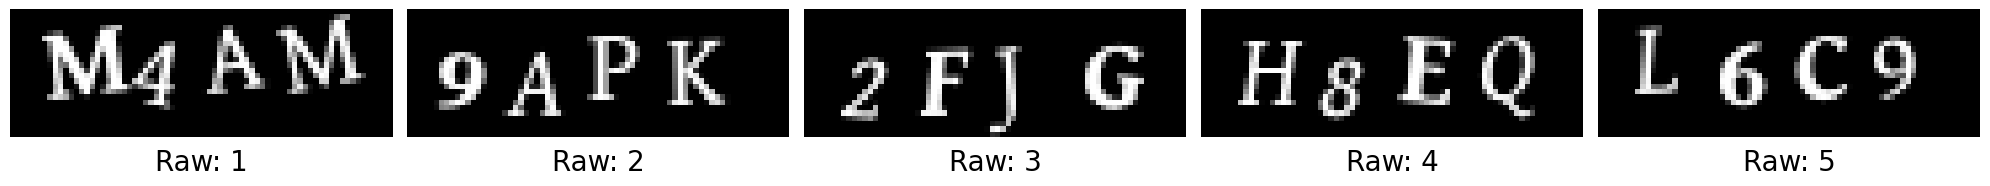

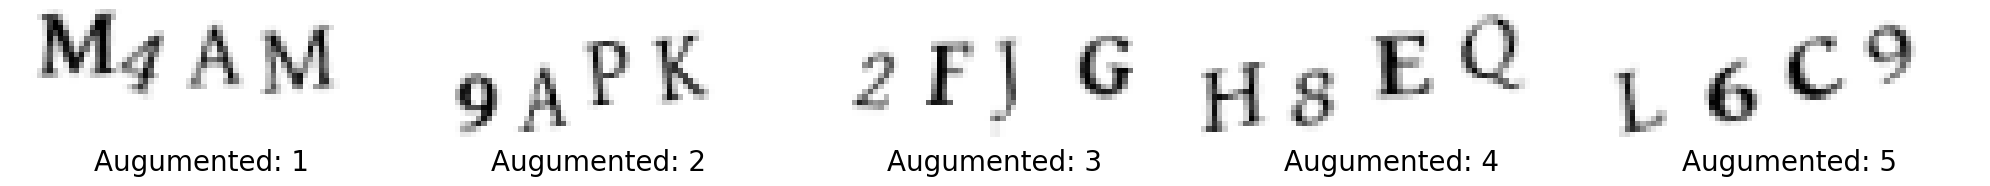

In [328]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def invert_rescale_pixels(image):
    """ Invert and rescale pixels of CAPTCHA images. """
    ## [ TODO ]
    # 1) Rescale pixel grayscale values to [0, 1]
    # 2) Invert the grayscales of the image
    # 3) Return modified grayscales
    image=image.reshape(len(image),image.shape[1],image.shape[2])
    rows,cols = image.shape[1:3]
    emptyImage = np.zeros((len(image),rows,cols))
    for i in range(len(image)):
        image[i]= image[i]/255
    for i in range(len(image)):
        for h in range(rows):
            for j in range(cols):
                emptyImage[i,h,j] = 1- image[i,h,j]
    return emptyImage
## [ TODO ]
# Add following random effects to CAPTCHA images using `ImageDataGenerator`:
#
# 1) Rotation
# 2) Horizontal shift
# 3) Vertical shift
# 4) Shearing
# 5) Zooming in or out
# 6) Apply `invert_rescale_pixels` as the preprocessing function
#
# Choose appropriate parameters for these random effects, such that original
# CAPTCHAs are moderately distorted but all letters and digits can still be
# identified.
#
# Code below will help you preview the effects of your choice.
captcha_transformer = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=5,
        zoom_range=0.2,
        preprocessing_function=invert_rescale_pixels)

# Select a few images for preview
preview_orig = captcha_images_train[:5]
# Generate a few transformed CAPTCHA images for preview
preview_iter = captcha_transformer.flow(preview_orig, batch_size=5, shuffle=False)
preview_trans = next(preview_iter)


# Preview original and transformed CAPTCHAs
hw2_util.print_images(
    
    preview_orig.squeeze(),
    texts=[f"Raw: {i+1}" for i in range(5)]
)
hw2_util.print_images(
    preview_trans.squeeze(),
    texts=[f"Augumented: {i+1}" for i in range(5)]
)

Apart from the inversion of grayscale, you should be able to observe slight differences between original and transformed images. These transformed CAPTCHAs should still be easily recognizable, though.

## Training

From now on, we will shift our focus to the end-to-end neural network model. We assume our neural network model takes the whole CAPTCHA image as input and outputs four probability distributions for each character. In other words, if we have `n_classes` distinct characters in all CAPTCHAs, the output of our model would be a NumPy array of shape `(4, n_classes)`. From each prediction distribution, we choose the character with highest probability, and we define a correct prediction as the one with all four characters correctly predicted.

Our first task is to rewrite the accuracy metric for our task, since Keras's built-in accuracy metric does not work with the output of our neural network. Both `actual_one_hot` (True one-hot encoded labels) and `pred_dist` (Prediction  probabilities) are batch tensors of shape `(*, 4, n_classes)`. Here we use Tensorflow operations, which are similar to NumPy functions, to compute our modified accuracy metric from inputs:

In [329]:
import tensorflow as tf

def multi_acc(actual_one_hot, pred_dist):
    """ Compute the accuracy of CAPTCHA recognition. """
    # Get character classes for samples
    actual_classes = tf.argmax(actual_one_hot, axis=-1)
    pred_classes = tf.argmax(pred_dist, axis=-1)
    
    # Get correctness for prediction
    pred_correct = tf.reduce_all(tf.equal(actual_classes, pred_classes), axis=-1)
    pred_correct = tf.cast(pred_correct, dtype=pred_dist.dtype)
    
    # Compute accuracy
    return tf.reduce_mean(pred_correct)

Next, we will complete `build_model` function which is responsible for building the neural network model. The neural network starts with several "convolution blocks" as usual, each of which contains a convolution layer for feature extraction and a max pooling layer for dimensionality reduction. The latter part of the network is however different from lab 4 in that **we replace regular fully-connected layers (implemented with linear layers) with "zone-wise" fully-connected layers (implemented with convolution layers)**. Below is the structure of our network:

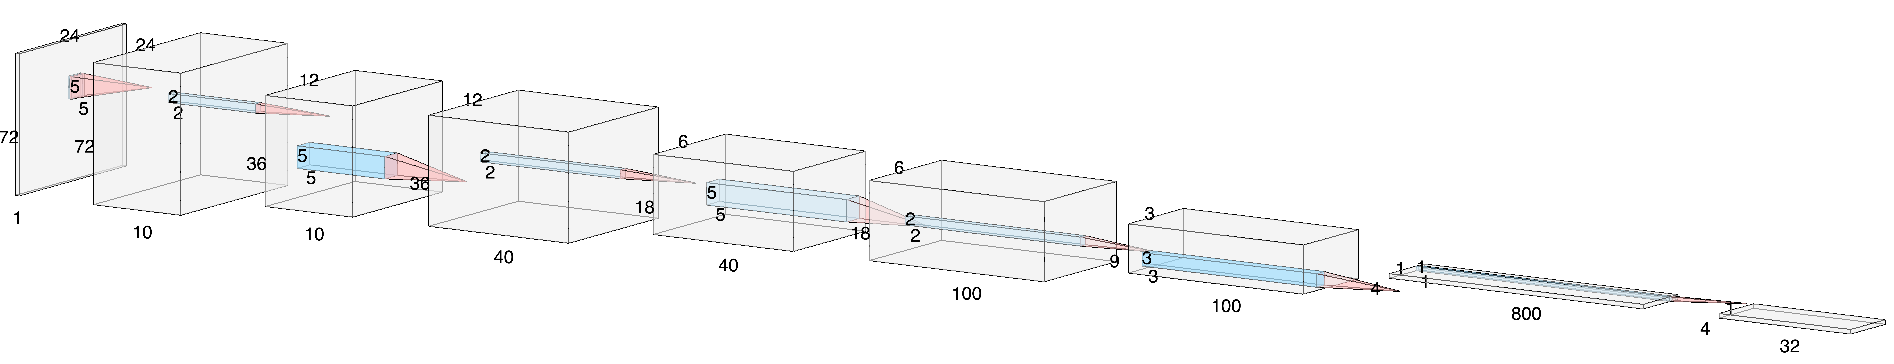

We also substitute the categorical cross-entropy loss for binary cross-entropy loss and make use of our custom accuracy metric due to the unique output format of our model.

In [295]:
from tensorflow.keras import Sequential, layers

def build_model(n_classes):
    """ Build the neural network model for CAPTCHA classification. """
    # Build a feed-forward neural network
    # The input shape of the model is (*, 24, 72, 1)
    model = Sequential()

    ## [ TODO ]
    # Complete the implementation of the basic neural network
    
    # First convolution block: (*, 24, 72, 1) -Conv2D+ReLU-> (*, 24, 72, 10) -MaxPooling2D-> (*, 12, 36, 10)
    # 1) Convolution layer: 10 channels, 5*5 kernel, ReLU activation, padded to maintain same shape
    # 2) Max pooling layer: 2*2 kernel
    model.add(layers.Conv2D(10,(5,5), padding = "same", activation = "relu", input_shape =(24,72,1)))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))

    # Second convolution block: (*, 12, 36, 10) -Conv2D+ReLU-> (*, 12, 36, 40) -MaxPooling2D-> (*, 6, 18, 40)
    # (Parameters have same meanings as the first block)
    model.add(layers.Conv2D(40,(5,5), padding = "same", activation = "relu"))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    
    # Third convolution block: (*, 6, 18, 40) -Conv2D+ReLU-> (*, 6, 18, 100) -MaxPooling2D-> (*, 3, 9, 100)
    # (Parameters have same meanings as the first block)
    model.add(layers.Conv2D(100,(5,5), padding = "same", activation = "relu"))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))

    # "Zone-wise" fully-connected layer: (*, 3, 9, 100) -Conv2D+ReLU-> (*, 1, 4, 800)
    # Convolution layer: 800 channels, 3*3 kernel, ReLU activation,
    #   horizontal stride set to 2 to obtain 4 zones, no padding
    model.add(layers.Conv2D(800,(3,3),strides=(2,2), padding = "valid", activation = "relu"))
    
    # "Zone-wise" fully-connected layer: (*, 1, 4, 800) -Conv2D-> (*, 1, 4, n_classes)
    # Convolution layer: `n_classes` channels, 1*1 kernel, no activation,
    #   no padding, used for dimensionality reduction
    model.add(layers.Conv2D(n_classes,(1,1), padding = "valid"))
    
    # Reshape and apply softmax on last dimension: (*, 1, 4, n_classes) -Reshape+Softmax-> (*, 4, n_classes)
    model.add(layers.Reshape((4,n_classes)))
    model.add(layers.Softmax())
    
    # Build classification model with Adam optimizer and cross entropy loss
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=[multi_acc])
    
    return model

Finally, the `train_model` function takes care of the training of the model. It generates transformed CAPTCHA images from both training and validation set, which will be consumed by the model during training. We compute the steps of training and validation such that the whole training and validation set, with data augmentation applied, are iterated exactly once every epoch.

In [296]:
import math

def train_model(model, batch_size=5, n_epochs=40, seed=42):
    ## [ TODO ]
    # 1) Pass training CAPTCHA images and one-hot encoded texts through `captcha_transformer`,
    #    name the result image iterator as `iter_train`.
    # 2) Pass validation CAPTCHA images and one-hot encoded texts through `captcha_transformer`,
    #    name the result image iterator as `iter_vali`.
    #    (Note: for both questions, set the batch size and random number generator seed)
    #    (Hint: refer to data augmentation effect preview code if you don't have a clue)
    # 3) Compute the number of training and validation steps (`steps_train` and `steps_vali`) for each epoch.
    #    When the epoch completes, all training and validation samples should have been iterated exactly once.
    iter_train=captcha_transformer.flow(captcha_images_train,texts_one_hot_train, batch_size=batch_size,seed=seed)
    iter_vali=captcha_transformer.flow(captcha_images_vali, texts_one_hot_vali,batch_size=batch_size,seed=seed)
    steps_train=len(iter_train)//batch_size
    steps_vali=len(iter_vali)//batch_size    

    
    # Start training
    
    return model.fit_generator(
        generator=iter_train,
        steps_per_epoch=steps_train,
        epochs=n_epochs,
        validation_data=iter_vali,
        validation_steps=steps_vali,
        verbose=1
    )

Ok, it's time to put everything together. We will build our model, train our model for some epochs and save it as `model-basic.h5`:

In [297]:
# Build a basic CNN model
model_basic = build_model(n_classes)

# Train the basic model for 100 epochs
history_basic = train_model(model_basic, n_epochs=100)

# Store the basic model in file
model_basic.save("./model-basic.h5")


d:\anaconda\envs\tf_gpu\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
27/27 [==============================] - 1s 31ms/step - loss: 0.1380 - multi_acc: 0.0000e+00 - val_loss: 0.1372 - val_multi_acc: 0.0000e+00
Epoch 2/100
27/27 [==============================] - 1s 26ms/step - loss: 0.1370 - multi_acc: 0.0000e+00 - val_loss: 0.1357 - val_multi_acc: 0.0000e+00
Epoch 3/100
27/27 [==============================] - 1s 26ms/step - loss: 0.1351 - multi_acc: 0.0000e+00 - val_loss: 0.1323 - val_multi_acc: 0.0000e+00
Epoch 4/100
27/27 [==============================] - 1s 26ms/step - loss: 0.1325 - multi_acc: 0.0000e+00 - val_loss: 0.1300 - val_multi_acc: 0.0000e+00
Epoch 5/100
27/27 [==============================] - 1s 25ms/step - loss: 0.1273 - multi_acc: 0.0000e+00 - val_loss: 0.1208 - val_multi_acc: 0.0000e+00
Epoch 6/100
27/27 [==============================] - 1s 26ms/step - loss: 0.1219 - multi_acc: 0.0000e+00 - val_loss: 0.1159 - val_multi_acc: 0.0000e+00
Epoch 7/100
27/27 [==============================] - 1s 25ms/step - loss: 0.1165 - multi

## Evaluation

We have obtained a trained model as well as the training history during the previous stage. The training history contains the loss and accuracy of the nerual network as the training process proceeded. To show their trend during training, we plot these metrics for both training and validation set:

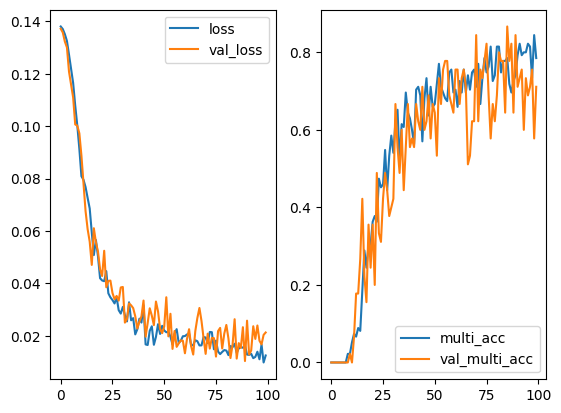

In [300]:
from matplotlib import pyplot as plt

## [ TODO ]
# 1) Plot the loss of the model during training for both training set and validation set.
#    (Hint: for Keras history object `h`, loss can be found at `h.history["loss"]` and `h.history["val_loss"]`)
# 2) Plot the accuracy of the model during training for both training set and validation set.
#    (Hint: for Keras history object `h`, accuracy can be found at `h.history["multi_acc"]`
#     and `h.history["val_multi_acc"]`; this is specific to this homework)
#    (Note: for each question, plot all curves for the same metric on the same graph for comparison)

plt.subplot(121)
plt.plot(history_basic.history['loss'],label='loss')
plt.plot(history_basic.history['val_loss'],label='val_loss')
plt.legend()

plt.subplot(122)
plt.plot(history_basic.history['multi_acc'],label='multi_acc')
plt.plot(history_basic.history['val_multi_acc'],label='val_multi_acc')
plt.legend()
plt.show()

Next, we evaluate our model end-to-end on the test set. Like training and validation set, we transform test set CAPTCHA images through data augmentation. We then predict the characters for these images and compare the predictions with ground truth. Similar to lab 4, we compute the accuracy of our model and show samples of correct and incorrect predictions:

In [462]:
def evaluate_model(model, n_classes, n_rounds=5, n_display_samples=10, batch_size=5, seed=42):
    ## [ TODO ]
    # 1) Pass test CAPTCHA images and one-hot encoded texts through `captcha_transformer`,
    #    name the result image iterator as `iter_test`.
    #    (Note: set the batch size and random number generator seed)
    # 2) Compute the number of test steps (`steps_test`) for each epoch.
    #    When the epoch completes, all test samples should have been iterated exactly once.
    iter_test = captcha_transformer.flow(captcha_images_test, captcha_texts_test, batch_size=batch_size, shuffle=False)
    steps_test=len(iter_test)//batch_size
    d=np.unique(list(hw2_util.flatten(list(captcha_texts_test))))
    # Number of test samples and correct predictions
    n_test = n_correct = 0
    # Correct and incorrect samples
    correct_samples = []
    incorrect_samples = []
    
    for _ in range(n_rounds*steps_test):
        images_batch, texts_batch = next(iter_test)
        
        ## [ TODO ]
        # 1) Predict characters with neural network model
        # 2) Reshape one-hot prediction to 2D NumPy array of shape (4*batch_size, n_classes)
        # 3) Decode ont-hot predictions
        # 4) Group every 4 characters together for a CAPTCHA
        #    (Hint: `hw2_util.group_every` can help you with that)
        # 5) For each CAPTCHA, its prediction and actual text:
        #    - Update number of correct predictions
        #    - Collect `n_display_samples` correct samples of tuple (image, prediction) for review
        #    - Collect `n_display_samples` incorrect samples of tuple (image, prediction, actual) for review
        #      (Caution: DO NOT print ALL correct / incorrect images; this is slow and the output will be messy!)
        pred=model.predict(images_batch)
        pred=pred.reshape(4*batch_size,n_classes)
        classes=np.argmax(pred,axis=1)
        pred_text=[]
        for i in classes:
                pred_text.append(d[i])
        pred_text=list(hw2_util.group_every(pred_text,4))
        a=[]
        for i in pred_text:
            a.append(''.join(i))
        for i in range(len(a)):
            if a[i]==texts_batch[i]:
                n_correct+=1
                if len(correct_samples)<=n_display_samples:
                    correct_samples.append((images_batch[i],texts_batch[i]))
            else:
                if len(incorrect_samples)<=n_display_samples:
                    incorrect_samples.append((images_batch[i],a[i],texts_batch[i]))
        n_test+=batch_size
    # Show statistics
    print("# of test CAPTCHAs:", n_test)
    print("# correctly recognized:", n_correct)
    print("Accuracy:", n_correct/n_test, "\n")
    
    # Show all correct predictions
    hw2_util.print_images(
        hw2_util.unzip(correct_samples)[0],
        texts=[f"Correct: {actual}" for _, actual in correct_samples],
        n_rows=2
    )

    # Show all incorrect predictions
    hw2_util.print_images(
        hw2_util.unzip(incorrect_samples)[0],
        texts=[
            f"Prediction: {pred}\nActual: {actual}" \
            for _, pred, actual in incorrect_samples
        ],
        n_rows=2,
        fig_size=(20, 6),
        text_center=(0.5, -0.25)
    )

Now we run the evaluation process on the basic model:

# of test CAPTCHAs: 225
# correctly recognized: 155
Accuracy: 0.6888888888888889 

Figure(2000x500)
Figure(2000x600)


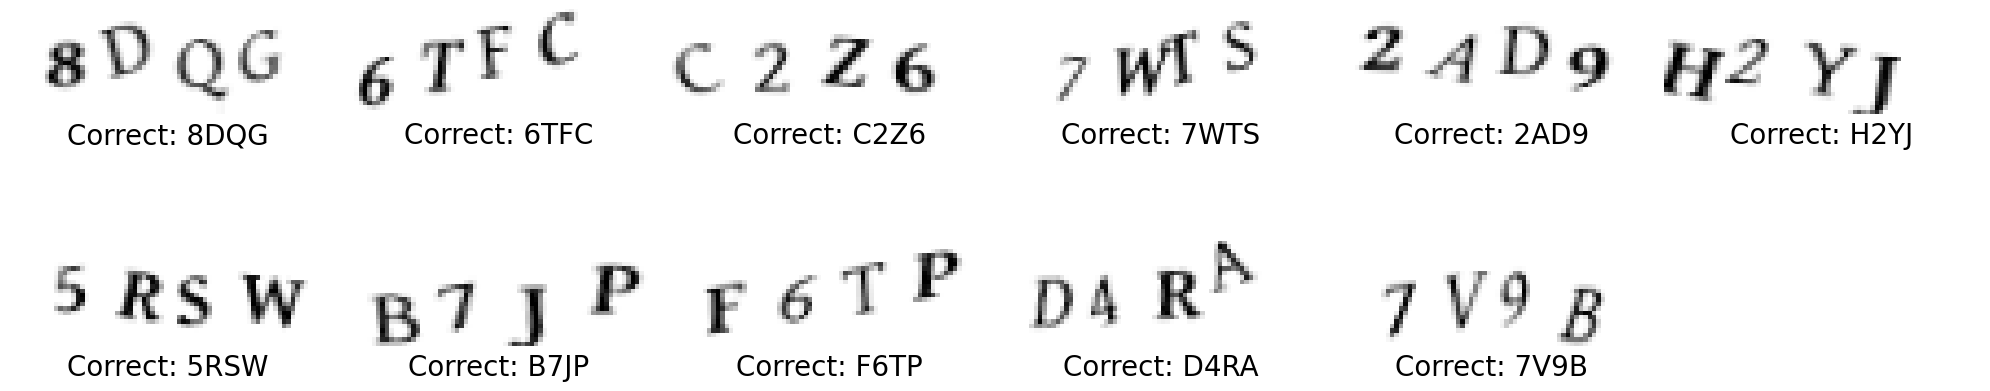

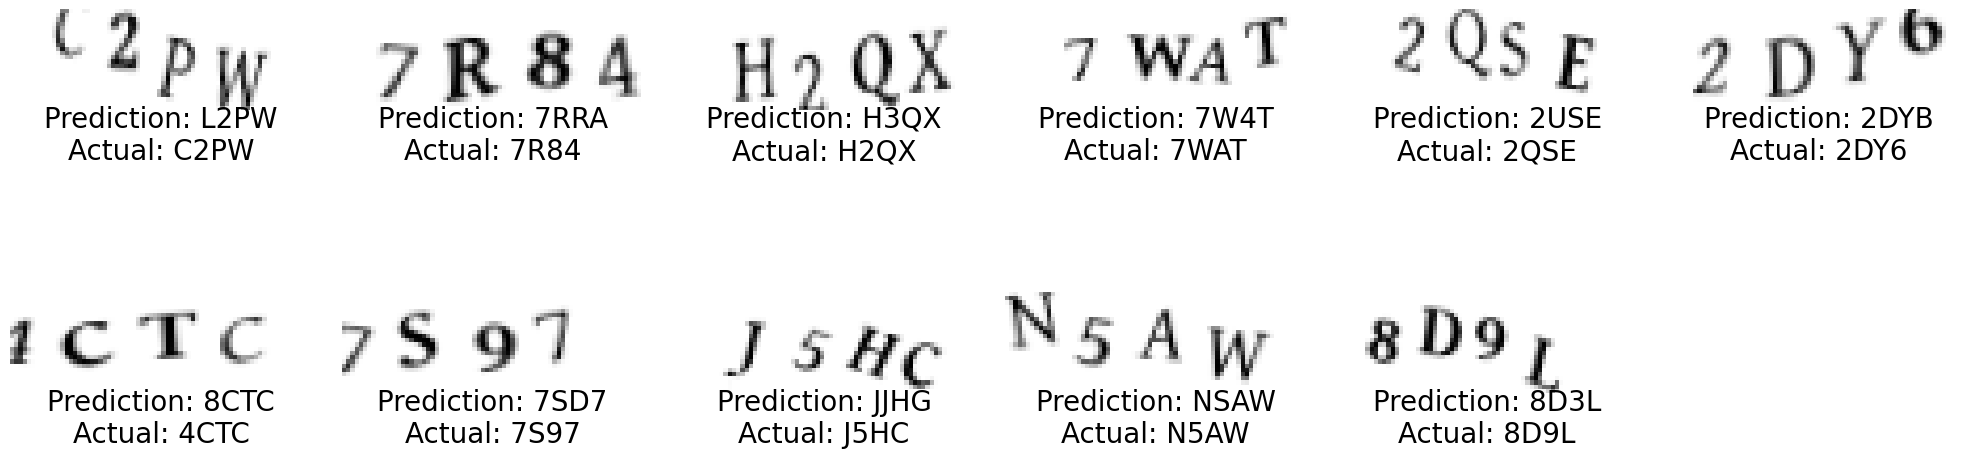

In [463]:
# Evaluate the basic model
evaluate_model(model_basic, n_classes)

## Improvements (Optional; Not Graded)

Like homework 1, **you can optionally choose to work on two improvements to the neural network model**, and see if these modifications help with the accuracy. Please note that we won't grade your solutions for these questions, but we may give you feedbacks should you choose to complete them. We also encourage you to **reuse previous code and functions** as much as possible, and avoid repeating identicial code from previous part of this homework.

***

   Neural network models are susceptible to over-fitting problems due to their huge amount of free parameters. When neural network model overfits, it performs extremely well on the training set, but can easily fail when new samples are added. There are three possible approaches to mitigate the over-fitting issue:

  * Adding regularization (L1 and/or L2) to parameters of each linear or convolution layer.
  * Adding dropout layers (`keras.layers.Dropout`) to the model.
  * Adding batch normalization layers (`keras.layers.BatchNormalization`) to the model.
  
Try one or a few of these approaches and compare their performance with the original model. Complete the following tasks by adding code and text cells below:
  
  * Specify your choice of approaches and the details for each approach:
    - For regularization, this is the type of regularization and regularization factor for each convolution and linear layer.
    - For dropout layers, specify the number, position and dropout rate of all dropout layers.
    - For batch normalization layers, specify the number and position of all batch normalization layers.
  * Plot the loss and accuracy for both training and validation set. Think about what curves to put on the same plot.
    - One idea is to put the same metric of all four models (basic model and three improvement models) for the same set (e.g. training set) on the same plot. In this case, you will get four plots in the end.
    - You don't need to include plots as images in the notebook. Instead, just provide the code that can plot these curves.
  * Finally, report the accuracy of all three improvement models on the test set.

## Questions

1. What is the purpose and benefits of data augmentation?
   - Hint: look at the size and complexity of the CAPTCHA dataset.

2. What is the purpose of 1\*1 convolution kernel?
   - Hint: Compare the 1\*1 convolution layer in this homework with fully-connected layers in lab 4.

3. **(Optional; Not Graded)** What is the purpose of dropout? Does it work on improving the convergence of training or on generalization? Give some reasons to support your idea.

4. **(Optional; Not Graded)** What is the purpose of batch normalization? Does it work on improving the convergence of training or on generalization? Give some reasons to support your idea.

## Submission

When you have finished this homework, please submit an archive with this notebook (`homework-2-student.ipynb`) and the basic neural network model (`model-basic.h5`).

## References

1. Keras API reference: https://keras.io/
2. Tensorflow API reference: https://www.tensorflow.org/api_docs
3. Over-fitting: https://en.wikipedia.org/wiki/Overfitting
4. Residual neural network: https://en.wikipedia.org/wiki/Residual_neural_network
5. Residual blocks - Building blocks of ResNet: https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec